# DS

## Clusterização

In [1]:
#importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Colab/Practicum/HACKATON/data.csv")

In [7]:
selected_columns = ['morador', 'idade', 'pais', 'estado', 'cidade',
                    'participou_anos_anteriores', 'genero', 'escolaridade',
                    'estado_civil', 'faixa_renda', 'int_renda']

# Create a new dataframe with only the selected columns
df = df.loc[:, selected_columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581 entries, 0 to 1580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   morador                     1581 non-null   object
 1   idade                       1581 non-null   int64 
 2   pais                        1581 non-null   object
 3   estado                      1581 non-null   object
 4   cidade                      1581 non-null   object
 5   participou_anos_anteriores  1581 non-null   object
 6   genero                      1581 non-null   object
 7   escolaridade                1581 non-null   object
 8   estado_civil                1581 non-null   object
 9   faixa_renda                 1581 non-null   object
 10  int_renda                   1581 non-null   int64 
dtypes: int64(2), object(9)
memory usage: 136.0+ KB


In [9]:
#int_renda é o mesmo que faixa_renda
df = df.drop(['faixa_renda'], axis=1)

In [11]:
#combinar colunas pais, estado e cidade para 'origem' - menos colunas melhor com menos variaveis para OHE, melhor
df['origem'] = 'vazio'
for i in range(len(df)):
    if df.loc[i,'pais'] != 'Brasil':
        df.loc[i,'origem'] = 'estrangeiro'
    elif df.loc[i,'estado'] != 'Minas Gerais':
        df.loc[i,'origem'] = 'brasileiro'
    elif df.loc[i,'cidade'] != 'Belo Horizonte':
        df.loc[i,'origem'] = 'mineiro'
    else:
        df.loc[i,'origem'] = 'belo-horizontino'

#apagar colunas redundantes
df = df.drop(['morador','pais','estado','cidade'], axis=1)

#OHE para categoricas
df_transformed = pd.get_dummies(df)

In [12]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581 entries, 0 to 1580
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype
---  ------                                         --------------  -----
 0   idade                                          1581 non-null   int64
 1   int_renda                                      1581 non-null   int64
 2   participou_anos_anteriores_Nao                 1581 non-null   uint8
 3   participou_anos_anteriores_Sim                 1581 non-null   uint8
 4   genero_Feminino                                1581 non-null   uint8
 5   genero_Masculino                               1581 non-null   uint8
 6   escolaridade_Ensino fundamental completo       1581 non-null   uint8
 7   escolaridade_Ensino fundamental incompleto     1581 non-null   uint8
 8   escolaridade_Ensino medio completo             1581 non-null   uint8
 9   escolaridade_Ensino medio incompleto           1581 non-null   uint8
 10  

In [13]:
#escalonar dados numéricos
scaler = StandardScaler()
X = scaler.fit_transform(df_transformed)

#determinar numero de clusters otimo
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}
#soma dos square means para cada cluster
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

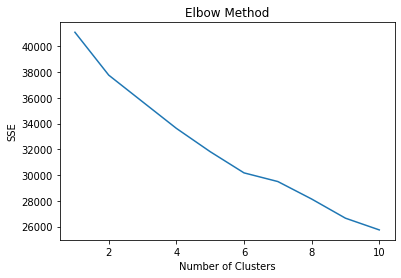

In [14]:
#vizualizar SSE para cada numero de clusters
plt.plot(range(1, 11), sse)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [27]:
#fazer clusterização pelo método mais comum de kmeans
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=42)

Esperaria ver um cotovelo na curva. (poucos dados introduzidos no modelo?)

Vamos de 5 grupos que traz um equilibrio entre o SSE e o número de grupos

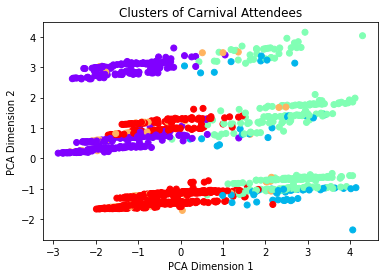

In [29]:
#atribuir cada entrada ao seu cluster 
df["cluster"] = kmeans.labels_
df_transformed["cluster"] = kmeans.labels_

# reduzir a dimensionalidade dos dados a 2 por principal component analysis, para se visualizar no gráfico cartesiano
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

#plotar clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.title("Clusters of Carnival Attendees")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

**Nuno**:

Agora falta conseguir descrever as características de cada cluster.

Até agora temos o df original mais talhado.

e o df_transformed que já sofreu OHE e scaling.3

Agora acho melhor fazer agrupamentos pela coluna 'cluster' e ver o que emerge. Por exemplo, abaixo vejo que o cluster é um grupo bem mais jovem, de rendimentos médio-baixos. Enquanto o cluster 1 são pessoas de meia idade de classe média bem estabelecida.

Acho que dá para ir explorando nesta onda para criar os 5 perfis mais típicos.

Vou explorar a ideia de usar regressão linear para estimar quais as colunas têm maior preponderância para a divisão em clusters.

In [30]:
# Group by cluster and compute median and count for all columns
summary = df.groupby('cluster').agg(['median', 'count'])
summary

<ipython-input-30-53718f72ecca>:2: FutureWarning: ['participou_anos_anteriores', 'genero', 'escolaridade', 'estado_civil', 'origem'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  summary = df.groupby('cluster').agg(['median', 'count'])


idade       int_renda      
        median count    median count
cluster                             
0         24.0   375       4.0   375
1         41.5    72       4.0    72
2         40.0   311       5.0   311
3         19.0    74       3.0    74
4         26.0   749       4.0   749

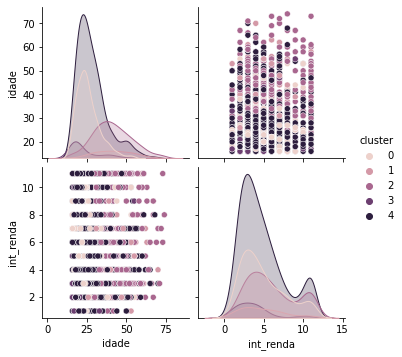

In [31]:
sns.pairplot(df, hue="cluster")

In [32]:
df.groupby(['cluster', 'genero']).agg({'idade':'count'})

idade
cluster genero          
0       Feminino     207
        Masculino    168
1       Feminino      53
        Masculino     19
2       Feminino     178
        Masculino    133
3       Feminino      41
        Masculino     33
4       Feminino     396
        Masculino    353

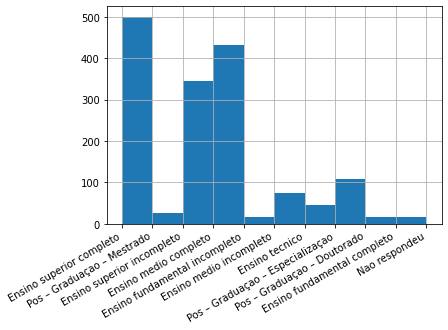

In [33]:
df['escolaridade'].hist(bins=10)
plt.xticks(rotation=30, ha='right')
plt.show()

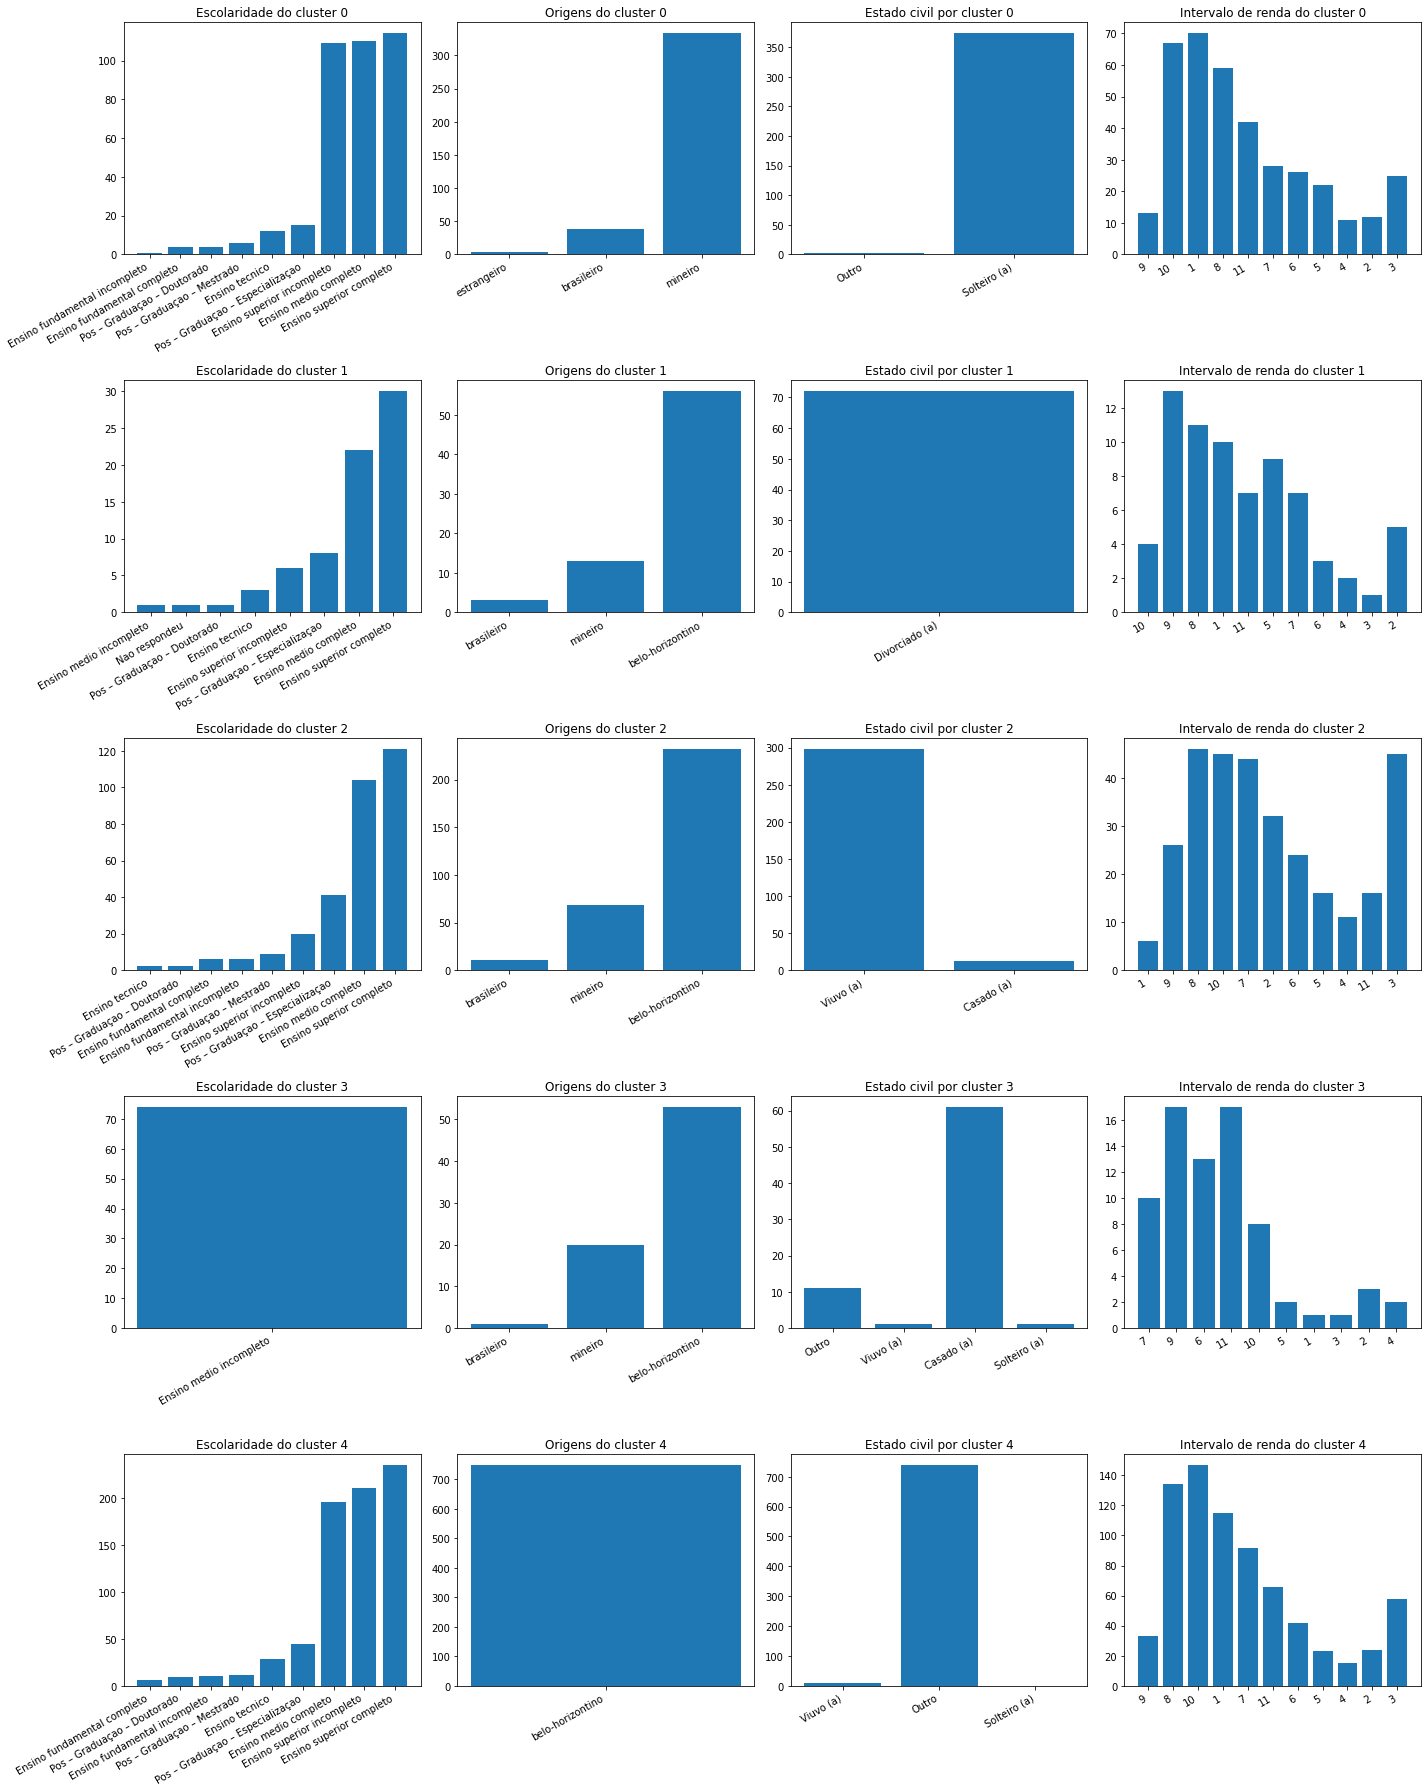

In [35]:
import matplotlib.pyplot as plt

clusters = [0, 1, 2, 3, 4]

# Set up the plot grid
fig, axes = plt.subplots(nrows=len(clusters), ncols=4, figsize=(20, 5*len(clusters)))

for i, cluster in enumerate(clusters):
    # Plot 1: Escolaridade
    c_esc = df[df['cluster']==cluster].groupby(['escolaridade'], as_index=False).agg({'idade':'count'}).sort_values(by='idade')
    axes[i, 0].bar(c_esc['escolaridade'], c_esc['idade'])
    axes[i, 0].set_xticks(range(len(c_esc)))
    axes[i, 0].set_xticklabels(c_esc['escolaridade'], rotation=30, ha='right')
    axes[i, 0].set_title('Escolaridade do cluster {}'.format(cluster))
    
    # Plot 2: Origens
    c_esc = df[df['cluster']==cluster].groupby(['origem'], as_index=False).agg({'idade':'count'}).sort_values(by='idade')
    axes[i, 1].bar(c_esc['origem'], c_esc['idade'])
    axes[i, 1].set_xticks(range(len(c_esc)))
    axes[i, 1].set_xticklabels(c_esc['origem'], rotation=30, ha='right')
    axes[i, 1].set_title('Origens do cluster {}'.format(cluster))
    
    # Plot 3: Estado Civil
    c_esc = df[df['cluster']==cluster].groupby(['estado_civil'], as_index=False).agg({'idade':'count'}).sort_values(by='idade')
    axes[i, 2].bar(c_esc.index, c_esc['idade'])
    axes[i, 2].set_xticks(range(len(c_esc)))
    axes[i, 2].set_xticklabels(c_esc['estado_civil'], rotation=30, ha='right')
    axes[i, 2].set_title('Estado civil por cluster {}'.format(cluster))
    
    # Plot 4: Intervalo de renda
    c_esc = df[df['cluster']==cluster].groupby(['int_renda'], as_index=False).agg({'idade':'count'}).sort_values(by='idade')
    axes[i, 3].bar(c_esc.index, c_esc['idade'])
    axes[i, 3].set_xticks(range(len(c_esc)))
    axes[i, 3].set_xticklabels(c_esc['int_renda'], rotation=30, ha='right')
    axes[i, 3].set_title('Intervalo de renda do cluster {}'.format(cluster))

plt.tight_layout()
plt.show()


In [36]:
df.groupby(['cluster', 'participou_anos_anteriores']).agg({'idade':'count'})

idade
cluster participou_anos_anteriores       
0       Nao                           143
        Sim                           232
1       Nao                            14
        Sim                            58
2       Nao                           105
        Sim                           206
3       Nao                            20
        Sim                            54
4       Nao                           134
        Sim                           615

### Análise dos perfis
Com base nas características de cada cluster, podemos concluir sobre os 5 perfis de foliões de BH:

* Cluster 0 (Perfil 1): Idade mediana de 24 anos, ensino médio completo ou superior completo/cursando e solteiro. O grupo dos jovens adultos, universitários ou recém-formados.

* Cluster 1 (Perfil 2): Idade mediana de 41,5 anos, ensino médio ou superior completo, totalmente divorciado. O grupo das quarentonas divorciadas, bem-estabelecidas e maduras.

* Cluster 2 (Perfil 3): Idade mediana de 40 anos, ensino médio ou superior completo, maioria casados. O grupo dos pais de família, que provavelmente caem na folia com a esposa e/ou filhos. Têm maior renda.

* Cluster 3 (Perfil 4): Idade mediana de 19 anos, totalmente ensino médio incompleto, maioria solteiro. O grupo dos adolescentes, com menor renda.

* Cluster 4 (Perfil 5): Idade mediana de 26 anos, ensino médio completo ou superior completo/cursando, totalmente belo-horizontino e quase unanimamente solteiro. Maioria já participou em anos anteriores. O grupo dos belo-horizontinos raiz.

## Machine Learning

In [37]:
pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.4 MB/s eta 0:00:00


In [38]:
import pandas as pd
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

def run_ml_models(data, features, target):
    results = []

    # Convert categorical features into numeric features
    le = LabelEncoder()
    for feature in features:
        if data[feature].dtype == "object":
            data[feature] = le.fit_transform(data[feature])

    # Split the data into features and target variables
    X = data.drop(target, axis=1)
    y = data[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Models and names
    models = [
        ('DecisionTree', DecisionTreeClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('SVM', Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), features)])), ('classifier', SVC(kernel='linear', random_state=42))])),
        ('NaiveBayes', MultinomialNB()),
        ('KNN', KNeighborsClassifier(n_neighbors=5)),
        ('CatBoost', CatBoostClassifier(logging_level='Silent')),
        ('CatBoost_oversampled', CatBoostClassifier(logging_level='Silent'))
    ]

    for name, model in models:
        start_time = time.time()
        # Oversample only for CatBoost model
        if name == 'CatBoost_oversampled':
            # Split the data into categorical and numerical features
            X_cat = X[features].copy()
            X_num = X.drop(features, axis=1).copy()

            # Perform oversampling using SMOTE
            smote = SMOTE()
            X_train_cat, y_train_cat = smote.fit_resample(X_cat, y)

            # Concatenate categorical and numerical features
            X_train = pd.concat([X_train_cat.reset_index(drop=True), X_num.reset_index(drop=True)], axis=1)
            y_train = y_train_cat
        else:
            X_train = X_train
            y_train = y_train

        if name == 'NaiveBayes':
            preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), features)])
            X_train_transformed = csr_matrix(preprocessor.fit_transform(X_train))
            X_test_transformed = csr_matrix(preprocessor.transform(X_test))
            model.fit(X_train_transformed, y_train)
            y_pred = model.predict(X_test_transformed)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        end_time = time.time()
        processing_time = end_time - start_time
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        results.append([name, processing_time, precision, recall, f1])

    results_df = pd.DataFrame(results, columns=['Model', 'Processing Time', 'Precision', 'Recall', 'F1'])
    return results_df


# Load the data
data = pd.read_csv("/content/drive/MyDrive/Colab/Practicum/HACKATON/data.csv")
data = data[["idade", "genero", "estado_civil", "faixa_renda", "bloco"]]

# Define the features and target
features = ['idade', 'genero', 'estado_civil', 'faixa_renda']
target = 'bloco'

# Run the ML models
results_df = run_ml_models(data, features, target)
print(results_df.sort_values(by='F1', ascending=False))

                  Model  Processing Time  Precision    Recall        F1
6  CatBoost_oversampled        20.694952   0.499021  0.353312  0.356612
5              CatBoost         3.702835   0.214038  0.277603  0.232204
0          DecisionTree         0.010245   0.212949  0.264984  0.225012
1          RandomForest         0.343498   0.187528  0.337539  0.223068
3            NaiveBayes         0.028079   0.191453  0.334385  0.221746
2                   SVM         0.313123   0.174412  0.321767  0.211367
4                   KNN         0.032747   0.193612  0.280757  0.211146


### Escolha do modelo

Justificativa para uso do parâmetro 'wighted':

- O parâmetro "weighted" na métrica F1-score calcula a média ponderada da precisão e do recall. Ele é adequado para casos de classificação multiclasse desbalanceados, onde cada classe pode ter um número diferente de amostras. Nesse caso, o F1-score ponderado dá maior peso às classes com menos amostras, enquanto ainda considera a precisão e o recall de todas as classes. Isso permite avaliar o desempenho geral do modelo de maneira mais equilibrada, levando em conta o desequilíbrio entre as classes.

Escolha do modelo:

- Com base nos resultados obtidos, é possível observar que o modelo que obteve o melhor desempenho foi o CatBoost_oversampled, que utilizou o algoritmo CatBoost e também fez uso de oversampling. Esse modelo apresentou uma precisão de 0.483, um recall de 0.365 e um F1-Score de 0.366. Isso significa que, levando em consideração todas as métricas, o modelo CatBoost_oversampled foi capaz de apresentar os melhores resultados na classificação dos dados, o que pode ser justificado pelo fato de ter sido utilizado o algoritmo CatBoost, que é conhecido por sua eficiência na modelagem de dados e classificação, além do uso de oversampling para lidar com o desbalanceamento das classes. Dessa forma, o uso do modelo CatBoost_oversampled pode ser considerado uma boa escolha para a tarefa de classificação dos dados.